In [1]:
import cv2     # opencv3
import glob    # to get lists of matching files
import numpy as np

from PIL import Image
from io import BytesIO

from matplotlib import pyplot as plt
%matplotlib inline

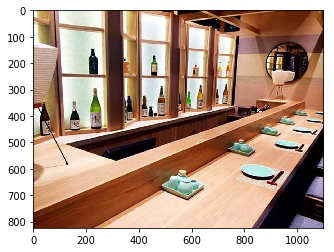

In [137]:
img = cv2.imread("../data/imgs/big_91252_83.jpg")

b,g,r = cv2.split(img)         # get b,g,r
img = cv2.merge([r,g,b]) 
# resized = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)

fig, ax = plt.subplots()
ax.imshow(img)

In [138]:
def image_sub_select(img, min_size=None, max_size=0.95):
    '''
    Inputs: 
    img: cv2/numpy array representing a loaded image
    min_size: the smallest proportion of the image to be cropped, with respect to the longer axis
                if min_size=None then figure out how big the image is relative to 299px square and
                allow zoom up to 0.5.
    max_size: the largest proportion of the image to be cropped, with respect the the longer axis
    
    This function, currently not part of a class, will randomly roll a zoom ratio from a uniform 
    distribution between the min_size and max_size.
    
    Returns:
    img but in the cropped form
    '''
    h, w = img.shape[0], img.shape[1]
    
    constraint = 0
    
    # experiment with large
    # what is smaller, width or height?
    if h > w:
        constraint = h
    else:
        constraint = w
    
#     print(img.shape)
    # (412, 550, 3)
    ogc = constraint  # remember the original size of the constraint
    
        
    # if min_size is None then figure out smallest min_size down to 0.5:
    if min_size is None:
        # how does constraint (smallest side) compare to 299px target size?
        con_ratio = 299.0 / constraint
        
        if con_ratio < 0.6:
            con_ratio = 0.6
        
        if con_ratio < 0.7:
            max_size -= 0.2
            
        crop_size = np.random.uniform(con_ratio, max_size)
    else:
        crop_size = np.random.uniform(min_size, max_size)
    
    constraint *= crop_size
#     print("crop_constraint", int(constraint))
    
    mid_x, mid_y = w / 2, h / 2
    tl_x, tl_y = int(mid_x - (constraint / 2)), int(mid_y - (constraint / 2))
    br_x, br_y = int(tl_x + constraint), int(tl_y + constraint)
    
#     print("initial top left", tl_x, tl_y)
#     print("initial bottom right", br_x, br_y)
    
    _range = ogc - constraint
#     print("range", int(_range))
    
    # figure out position within range
    x_pos = int(np.random.uniform(0, _range) - (_range / 2))
    y_pos = int(np.random.uniform(0, _range) - (_range / 2))
#     print("fuzz", x_pos, y_pos)
    
    tl_x, tl_y = int(tl_x + x_pos), int(tl_y + y_pos)
    
    # fix out of bounds for top left from using larger axis:
    if tl_x < 0:
        tl_x = 0
        
    if tl_y < 0:
        tl_y = 0
    
    br_x, br_y = int(tl_x + constraint), int(tl_y + constraint)
#     print("final top left", tl_x, tl_y)
#     print("final bottom right", br_x, br_y)
#     print("shape", img.shape)

    # fix out of bounds for bottom right from using larger axis:
    if br_x > img.shape[1]:
        # went too far right
#         print("went too far right")
        
        # figure out how much too far
        diff = img.shape[1] - br_x   
        
        # and fix
        br_x = img.shape[1] - 1
        tl_x += diff   # this is a negative value so add it
    
    if br_y > img.shape[0]:
        # went too far down
#         print("went too far down")
        
        # figure out how much too far
        diff = img.shape[0] - br_y
        
#         print("diff", diff)
        
        # then fix
        br_y = img.shape[0] - 1  
        tl_y += diff   # this is a negative value so add it
        
    
    return img[tl_y:br_y, tl_x:br_x, :]
    
# image_sub_select(img)

### Evaluate zoom cropping

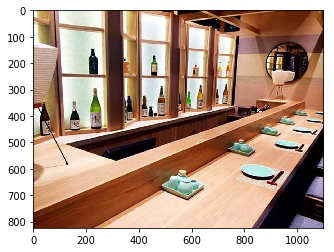

In [139]:
# starting image for reference

fig, ax = plt.subplots()
ax.imshow(img)

(785, 785, 3)


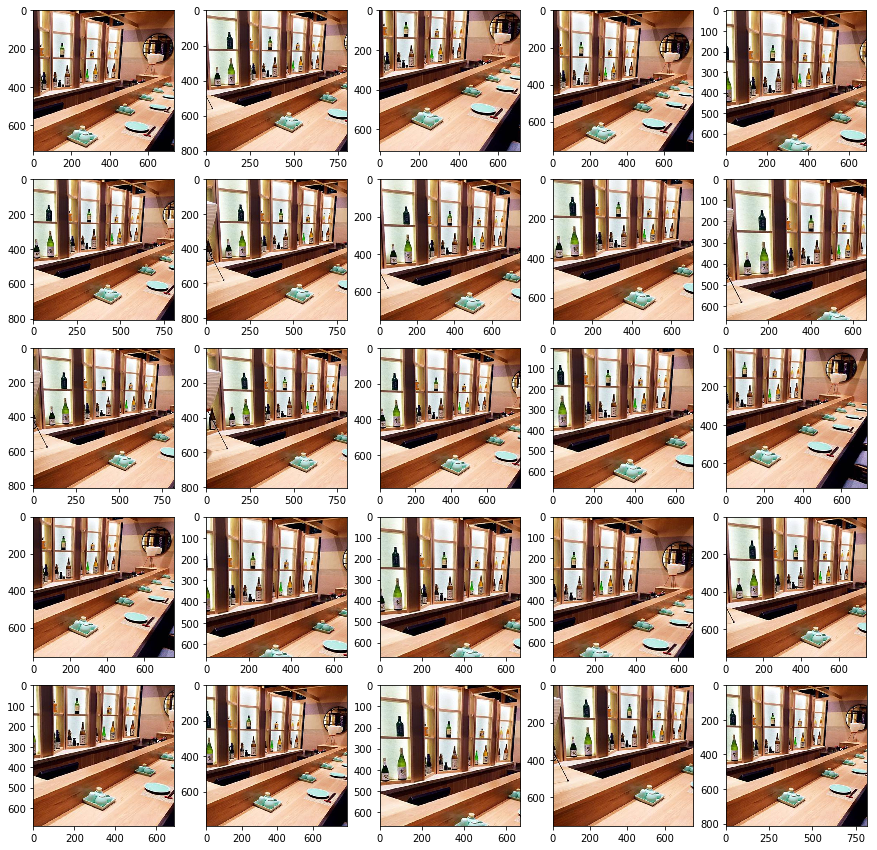

In [140]:
temp = image_sub_select(img)

print(temp.shape)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax in axs.flatten():
    temp = image_sub_select(img)
    ax.imshow(temp)
    
plt.show()

In [141]:
# rotation pre-processing

def random_rotation(img, min_angle=-15, max_angle=15):
    '''
    Inputs:
    img: numpy array representing an image in shape (height, width, 3)
    min_angle:  lowest possible angle to roll, typically -15
    max_angle:  highest possible angle to roll, typically 15
    
    returns:
    img as rotated numpy array
    '''
    angle = np.random.uniform(min_angle, max_angle)
    
    return rotate_bound(img, angle)
 
    
def rotate_bound(image, angle):
    # resource found here:
    # https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # figure out difference in new x and y to pass back
    w_diff, h_diff = nW - w, nH - h
#     print("angle", angle, "diff", w_diff, h_diff)
    
    # divide the difference in half in order to figure out top left
    w_hdiff, h_hdiff = w_diff // 2, h_diff // 2
    
    # crop out image back to previous size to prevent massive overcrop
    temp_img = cv2.warpAffine(image, M, (nW, nH))
    
    out_tlx, out_tly = w_hdiff, h_hdiff
    out_brx, out_bry = w_hdiff + w, h_hdiff + h
    
    # perform the actual rotation and return the image
    return temp_img[out_tly:out_bry, out_tlx:out_brx, :]

### Evaluation rotation then zooming

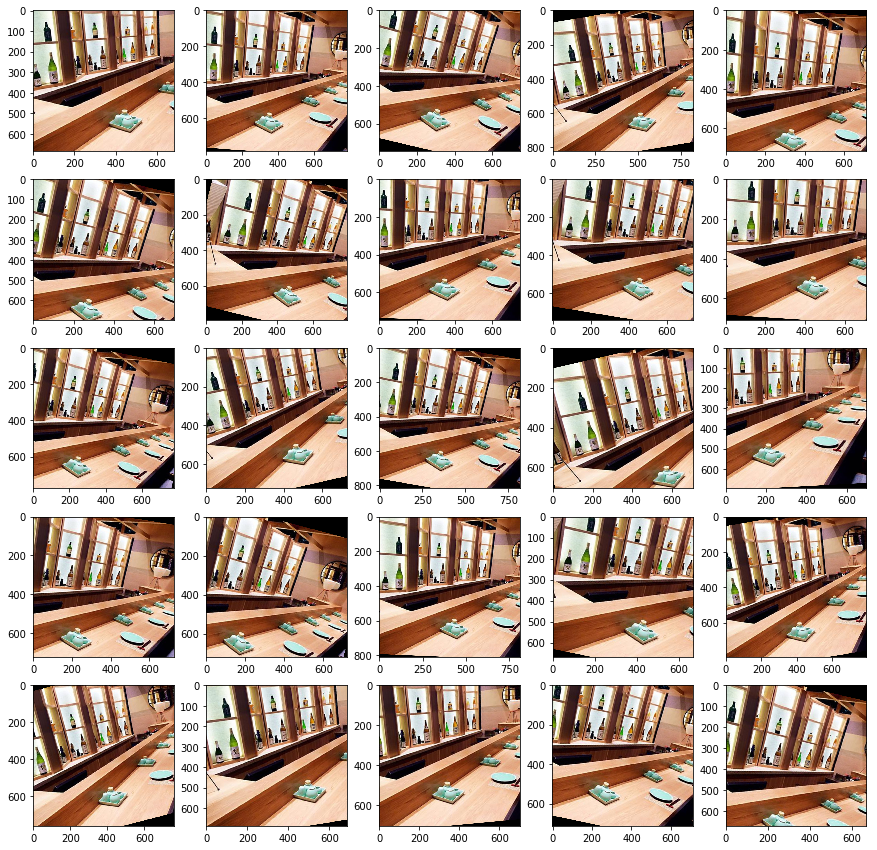

In [142]:
# temp = image_sub_select(img)

# print(temp.shape)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax in axs.flatten():
    temp = random_rotation(img, -15, 15)
    temp = image_sub_select(temp)
    ax.imshow(temp)
    
plt.show()

In [23]:
# img.shape   # (412, 550, 3)
mirror_img = img[:, ::-1, :]

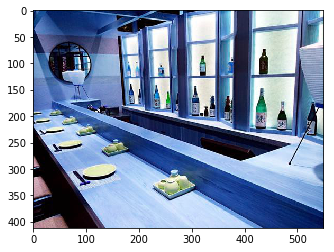

In [143]:

fig, ax = plt.subplots()
ax.imshow(mirror_img)

### Tested wide image scenario and seemed to work ok, now test tall image to make sure it works although surely this is a smaller part of the sample

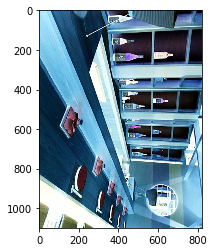

In [136]:
tall_img = cv2.imread("../data/imgs/tall_91252_83.jpg")

b,g,r = cv2.split(tall_img)         # get b,g,r
tall_img = cv2.merge([r,g,b]) 

fig, ax = plt.subplots()
ax.imshow(tall_img)

(727, 727, 3)


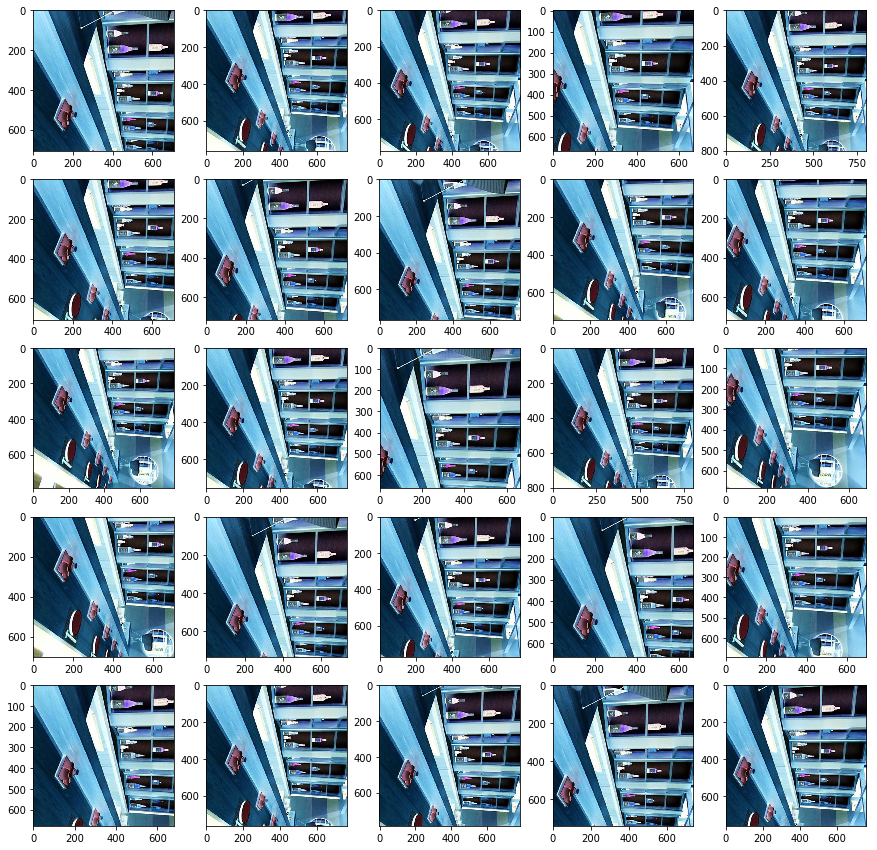

In [144]:
temp = image_sub_select(tall_img)

print(temp.shape)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax in axs.flatten():
    temp = image_sub_select(tall_img)
    ax.imshow(temp)
    
plt.show()

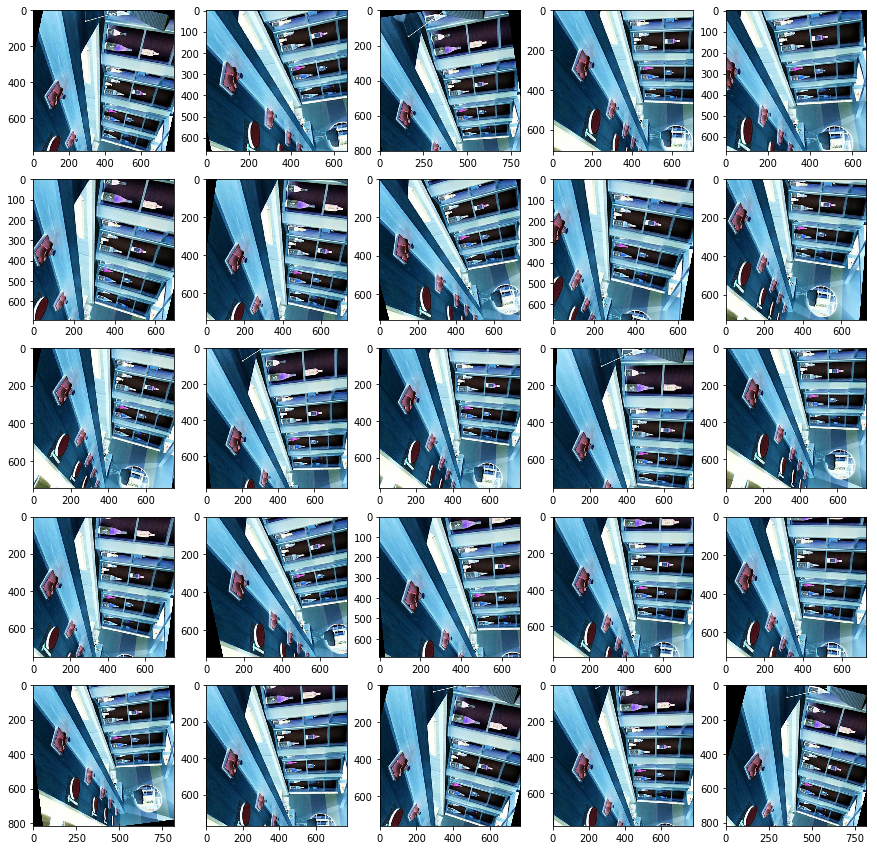

In [145]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax in axs.flatten():
    temp = random_rotation(tall_img, -15, 15)
    temp = image_sub_select(temp)
    ax.imshow(temp)
    
plt.show()